# Рябыкин Алексей 
# StepikID: 122154973

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [31]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import os
import pandas as pd
import skimage
import skimage.io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import numpy as np

from torch.utils.data import DataLoader
from time import time
from tqdm.notebook import tqdm
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import clear_output

In [2]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, downloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [3]:
data, attrs = fetch_dataset()

images not found, downloading...
extracting...
done
attributes not found, downloading...
done


In [4]:
data = torch.from_numpy(data).float().transpose(1,3)
assert data.shape[0] == attrs.shape[0]

In [5]:
attrs.sample(3)

Male     Asian     White     Black      Baby     Child     Youth  \
12749  1.274154  -1.95315  0.750419 -0.009984 -1.724305 -0.815798 -0.745853   
8945    0.56151 -0.503711  1.167312 -2.667539 -0.658299 -1.250314 -0.960526   
806    0.367096 -1.102053  0.673283 -1.594874 -2.141674 -1.555195 -1.409833   

      Middle Aged    Senior Black Hair  ... Pale Skin 5 o' Clock Shadow  \
12749    -0.15281 -0.252783  -1.545136  ... -1.140911          0.279874   
8945    -0.369828  0.026486  -1.864496  ...  0.404933         -0.125651   
806     -0.722085  0.994808  -1.447273  ... -0.387025         -0.729165   

      Strong Nose-Mouth Lines Wearing Lipstick Flushed Face High Cheekbones  \
12749                0.069023        -0.999545    -0.784484       -0.307399   
8945                -1.144656        -1.333047    -1.713381       -1.279561   
806                  1.590584        -0.509282    -1.329159        0.169382   

      Brown Eyes Wearing Earrings Wearing Necktie Wearing Necklace  
12749  -1.320832        -0.621102        0.190766        -0.471664  
8945   -0.735466        -0.935669        0.949125        -1.010457  
806    -0.720576        -0.391524        0.678421         0.365875  

[3 rows x 73 columns]

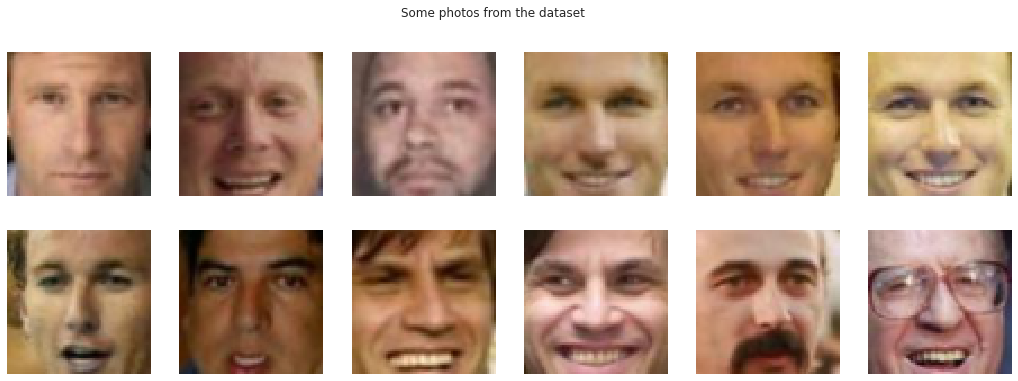

In [6]:
plt.figure(figsize=(18, 6))
for i in range(12):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(data[i].transpose(2,0), interpolation='nearest')
plt.suptitle('Some photos from the dataset')
plt.show();


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [7]:
train_data, test_data = train_test_split(data, test_size=0.3)

data_tr = DataLoader(train_data, batch_size=64, shuffle=True)
data_ts = DataLoader(test_data, batch_size=64, shuffle=False)

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [8]:
from copy import deepcopy
dim_code = 16**2
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16,
                      kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=64, 
                      kernel_size=3, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=256, 
                      kernel_size=5),  
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(36864, 2048),
            nn.ReLU(),
            nn.Linear(2048, dim_code)
        )
        self.decoder = nn.Sequential(
            nn.Linear(dim_code, 2048),
            nn.ReLU(),
            nn.Linear(2048, 36864),
            nn.Unflatten(1, (256, 12, 12)),
            nn.ConvTranspose2d(in_channels=256, out_channels=64,
                               kernel_size=5), 
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=16, 
                               kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=3,
                               kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def decode(self, x: torch.Tensor) -> torch.Tensor:
        reconstruction = self.decoder(x)
        return reconstruction
    
    def encode(self, x: torch.Tensor) -> torch.Tensor:
        latent_code = self.encoder(x)
        return latent_code

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        return reconstruction, latent_code

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [87]:
criterion = nn.MSELoss()

autoencoder = Autoencoder().to(device)

optimizer = optim.Adam(autoencoder.parameters(), lr=5e-4)

In [88]:
summary(autoencoder, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
            Conv2d-3           [-1, 64, 16, 16]           9,280
              ReLU-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 256, 12, 12]         409,856
              ReLU-6          [-1, 256, 12, 12]               0
           Flatten-7                [-1, 36864]               0
            Linear-8                 [-1, 2048]      75,499,520
              ReLU-9                 [-1, 2048]               0
           Linear-10                  [-1, 256]         524,544
           Linear-11                 [-1, 2048]         526,336
             ReLU-12                 [-1, 2048]               0
           Linear-13                [-1, 36864]      75,534,336
        Unflatten-14          [-1, 256,

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [3]:
from collections.abc import Iterable, Callable
import matplotlib
from IPython.display import clear_output

In [4]:
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 14}

matplotlib.rc('font', **font)

class Plotter():
    def __init__(self, epochs: int, count_photos: int=6,
                     figsize=(20,5)):
        super(Plotter, self).__init__()
        self.epochs = epochs
        self.count_photos = count_photos
        self.figsize = figsize
    
    def plot_info(self, batch: Iterable, reconstructed: Iterable, history: list, 
                    epoch: int=1, avg_loss_train: float=1e6):
        plt.figure(figsize=self.figsize)
        for k in range(self.count_photos):
            plt.subplot(2, self.count_photos, k+1)
            plt.imshow(batch[k].transpose(2,0).clip(0,1))
            plt.title('Real')
            plt.axis('off')
            plt.subplot(2, self.count_photos, k+self.count_photos+1)
            plt.imshow(reconstructed[k].transpose(2,0).detach().cpu().numpy().clip(0,1))
            plt.title('Recovered')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, self.epochs, avg_loss_train))
        plt.show()
        plt.figure(figsize=self.figsize)
        loss, val_loss = zip(*history)
        plt.plot(loss)
        plt.plot(val_loss)
        plt.legend(['train loss', 'validation loss'])
        plt.show()

In [11]:
def train(data_tr: Iterable, data_val: Iterable, epochs: int,
            model: nn.Module, loss_fn: Callable, opt: torch.optim, 
            scheduler: torch.optim.lr_scheduler=None) -> dict:
    X_val = next(iter(data_val))
    history = []
    plotter = Plotter(epochs=epochs, count_photos=6)
    for epoch in range(epochs):
        with tqdm(data_tr, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch + 1}")
            avg_loss_train = 0
            avg_loss_val = 0
            model.train()  # train mode
            for X_batch in tepoch:
                X_batch = X_batch.to(device, dtype=torch.float)
                opt.zero_grad()
                # set parameter gradients to zero
                # forward
                reconstruction, latent_code = model(X_batch)
                loss = loss_fn(reconstruction, X_batch)# forward-pass
                loss.backward()  # backward-pass
                opt.step()  # update weights
                if scheduler:
                    scheduler.step()
                # calculate loss to show the user
                avg_loss_train += loss / len(data_tr)
            # show intermediate results
            model.eval()  # testing mode
            reconstruction_val, latent_code = model(X_val.to(device))
            # validation loss
            for X_batch in data_val:
                X_batch = X_batch.to(device, dtype=torch.float)
                with torch.set_grad_enabled(False):
                    reconstruction, latent_code = model(X_batch)
                avg_loss_val += loss_fn(reconstruction, X_batch) / len(data_val)
            history.append((avg_loss_train.item(), avg_loss_val.item()))
            # Visualize tools
            tepoch.update(1)           
            clear_output()
            plotter.plot_info(X_val, reconstruction_val, history, epoch=epoch, 
                        avg_loss_train=avg_loss_train)
    return history

In [91]:
EPOCHS = 50

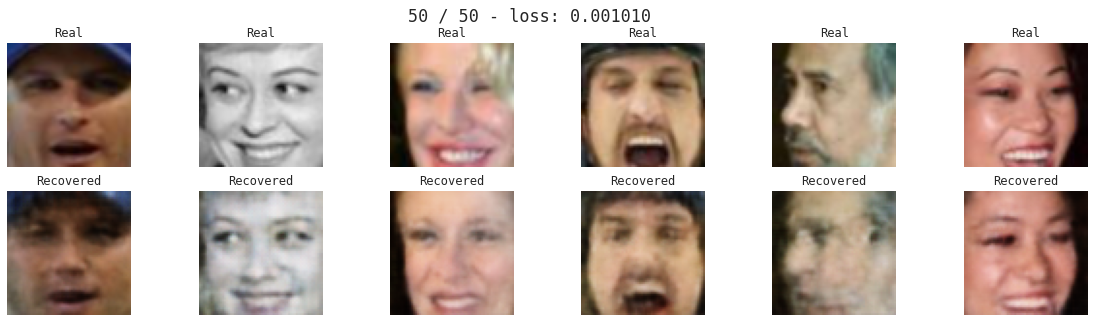

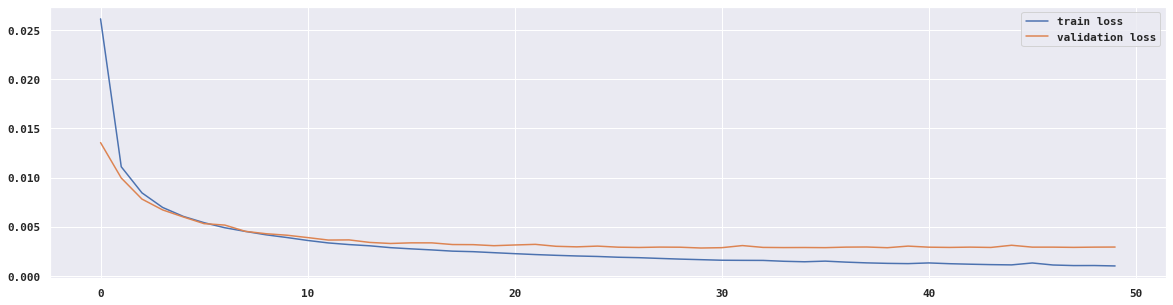

In [92]:
history = train(data_tr, data_ts, EPOCHS, autoencoder, criterion, optimizer)

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

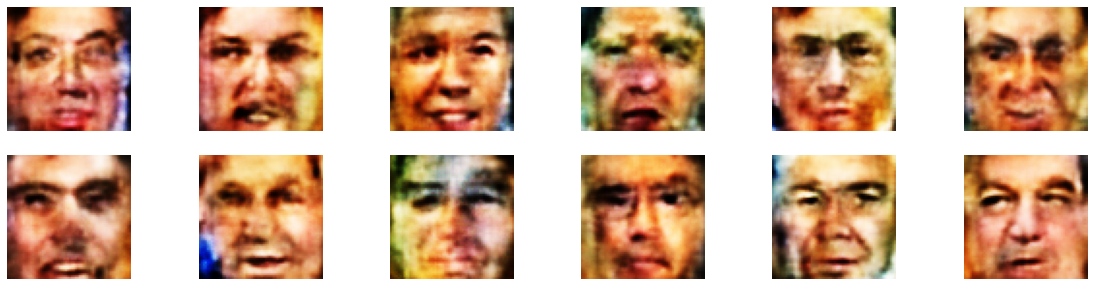

In [96]:
std_mu, std_sigma = 0, 1
z = std_mu + std_sigma * np.random.randn(15, dim_code)
z = torch.from_numpy(z).float().to(device)
output = autoencoder.decode(z).detach().cpu().data

fig, axes = plt.subplots(2, 6, figsize=(20,5))
for i, ax in enumerate(axes.flat):
    ax.imshow(output[i].transpose(2,0).numpy().clip(0,1))
    ax.axis('off')

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [6]:
def plot_images(batch: Iterable, title: str, count: int=12, figsize: tuple=(20,5)):
    plt.figure(figsize=figsize)
    count = min(len(batch), count)
    for k in range(count):
        plt.subplot(1, count, k+1)
        plt.imshow(batch[k].transpose(2,0).clip(0,1))
        plt.title(title)
        plt.axis('off')

def plot_transformed_images(before: Iterable, after: Iterable,
                            count: int=12, figsize: tuple=(20,5)):
    plt.figure(figsize=figsize)
    for k in range(count):
        plt.subplot(2, count, k+1)
        plt.imshow(before[k].transpose(2,0).clip(0,1))
        plt.title('Before')
        plt.axis('off')
        plt.subplot(2, count, k+count+1)
        plt.imshow(after[k].transpose(2,0).clip(0,1))
        plt.title('After')
        plt.axis('off')

def find_people(data: torch.Tensor, attrs: pd.DataFrame, category: str, count: int=15) -> torch.Tensor:
    indexes = attrs.sort_values(by=category, 
                            ascending=False).head(count).index.values
    return data[indexes]


def move_features(model:nn.Module, origin: torch.Tensor, target: torch.Tensor, count: int=15):
    latent_code_origin = model.encode(origin.to(device)) # which want to transform frowning
    latent_code_target = model.encode(target.to(device)) # which rules transformation smiling
    diff = latent_code_target.mean(axis=0) - latent_code_origin.mean(axis=0)
    reconstruction = model.decode((latent_code_origin + diff)).detach().cpu()
    return reconstruction, origin 
    

def make_people_happy(model:nn.Module, frowning_people: torch.Tensor, 
                      smiling_people: torch.Tensor=None, data: torch.Tensor=None, 
                      attrs: pd.DataFrame=None, count: int=15):
    if smiling_people is not None:
        reconstruction, origin = move_features(model, frowning_people, smiling_people)
        return reconstruction, origin
    else:
        assert data is not None, "Give me data"
        assert attrs is not None, "Give me attributes"
        smiling_people = find_people(data, attrs, 'Smiling', count)
        reconstruction, origin = move_features(model, frowning_people, smiling_people)
        
        
        return reconstruction, origin


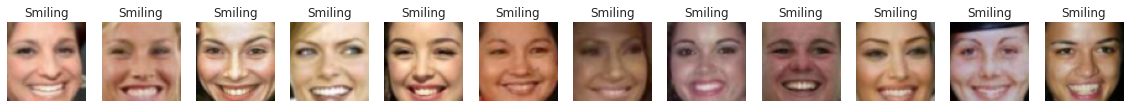

In [120]:
smiling_people = find_people(data, attrs, 'Smiling')
plot_images(smiling_people)

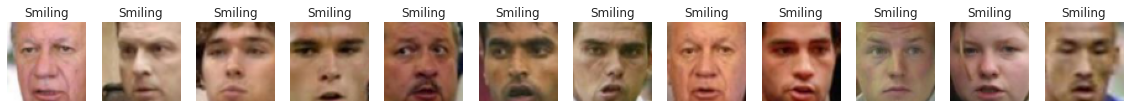

In [138]:
frowning_people = find_people(data, attrs, 'Frowning')
plot_images(frowning_people, 'Frowning')

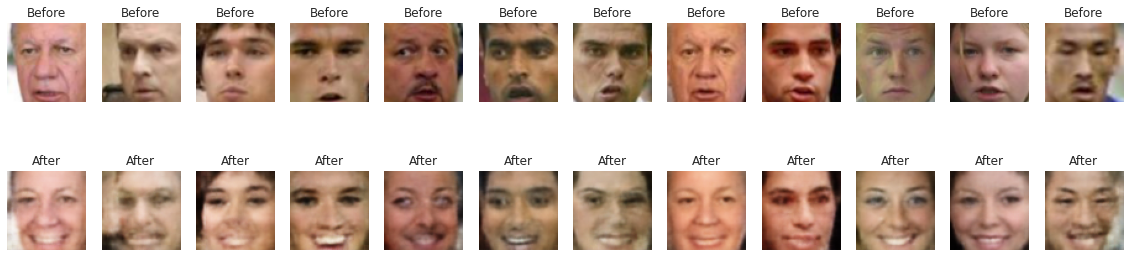

In [151]:
after, before = make_people_happy(autoencoder, frowning_people, smiling_people)
plot_transformed_images(before, after)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [5]:
batch_size = 64

# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [6]:
features = 16
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16,
                      kernel_size=3, stride=1),
            nn.LeakyReLU(negative_slope=0.25),
            nn.Dropout(p=0.75),
            nn.Conv2d(in_channels=16, out_channels=32,
                      kernel_size=3, stride=1, padding=0),
            nn.LeakyReLU(negative_slope=0.25),
            nn.Dropout(p=0.75),
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=3, stride=1),
            nn.LeakyReLU(negative_slope=0.25),
            nn.Dropout(p=0.8),
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=3, stride=1),
            nn.LeakyReLU(negative_slope=0.25),
            nn.Dropout(p=0.8),
            nn.Flatten(),
            nn.Linear(128*20*20, features*2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(features, 128*20*20),
            nn.Unflatten(1, (128, 20, 20)),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Dropout(p=0.8),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Dropout(p=0.8),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Dropout(p=0.8),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1),
            nn.Sigmoid())
        
    def encode(self, x):
        z = self.encoder(x).view(-1, 2, features)
        mu = z[:, 0, :]
        logsigma = z[:, 1, :]
        
        return mu, logsigma
    
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
        
    
    def decode(self, z):
        reconstruction = self.decoder(z)
        return reconstruction
    

    def forward(self, x):
        '''
        <используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        '''
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        
        return mu, logsigma, reconstruction

        

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [7]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss


def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)


def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [117]:
loss_fn = loss_vae

model = VAE()
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=5e-4)

In [118]:
EPOCHS = 50

In [8]:
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 14}

matplotlib.rc('font', **font)

class PlotterMNIST():
    def __init__(self, epochs: int, count_photos: int=6,
                     figsize=(20,5)):
        super(PlotterMNIST, self).__init__()
        self.epochs = epochs
        self.count_photos = count_photos
        self.figsize = figsize
    
    def plot_info(self, batch: Iterable, reconstructed: Iterable, history: list, 
                    epoch: int=1, avg_loss_train: float=1e6):
        plt.figure(figsize=self.figsize)
        for k in range(self.count_photos):
            plt.subplot(2, self.count_photos, k+1)
            plt.imshow(batch[k][0], cmap='gray', interpolation='nearest')
            plt.title('Real')
            plt.axis('off')
            plt.subplot(2, self.count_photos, k+self.count_photos+1)
            plt.imshow(reconstructed[k].detach().cpu().numpy().squeeze(), 
                       cmap='gray', interpolation='nearest')
            plt.title('Recovered')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, self.epochs, avg_loss_train))
        plt.show()
        plt.figure(figsize=self.figsize)
        loss, val_loss = zip(*history)
        plt.plot(loss)
        plt.plot(val_loss)
        plt.legend(['train loss', 'validation loss'])
        plt.show()

In [13]:
def train_vae(data_tr: Iterable, data_val: Iterable, epochs: int,
            model: nn.Module, loss_fn: Callable, opt: torch.optim, 
            scheduler: torch.optim.lr_scheduler=None) -> dict:
    X_val = next(iter(data_val))[0]
    history = []
    plotter = PlotterMNIST(epochs=epochs, count_photos=6)
    for epoch in range(epochs):
        with tqdm(data_tr, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch + 1}")
            avg_loss_train = 0
            avg_loss_val = 0
            model.train()  # train mode
            for X_batch, _ in tepoch:
                X_batch = X_batch.to(device, dtype=torch.float)
                opt.zero_grad()
                # set parameter gradients to zero
                # forward
                mu, log_sigma, reconstruction = model(X_batch)
                loss = loss_fn(X_batch, mu, log_sigma, reconstruction)# forward-pass
                loss.backward()  # backward-pass
                opt.step()  # update weights
                if scheduler:
                    scheduler.step()
                # calculate loss to show the user
                avg_loss_train += loss / len(data_tr)
            # show intermediate results
            model.eval()  # testing mode
            mu_val, log_sigma_val, reconstruction_val = model(X_val.to(device))
            # validation loss
            for X_batch, _ in data_val:
                X_batch = X_batch.to(device, dtype=torch.float)
                with torch.set_grad_enabled(False):
                    mu, log_sigma, reconstruction = model(X_batch)
                avg_loss_val += loss_fn(X_batch, mu, log_sigma, reconstruction) / len(data_val)
            history.append((avg_loss_train.item(), avg_loss_val.item()))
            # Visualize tools
            tepoch.update(1)           
            clear_output()
            plotter.plot_info(X_val, reconstruction_val, history, epoch=epoch, 
                        avg_loss_train=avg_loss_train)
    return history

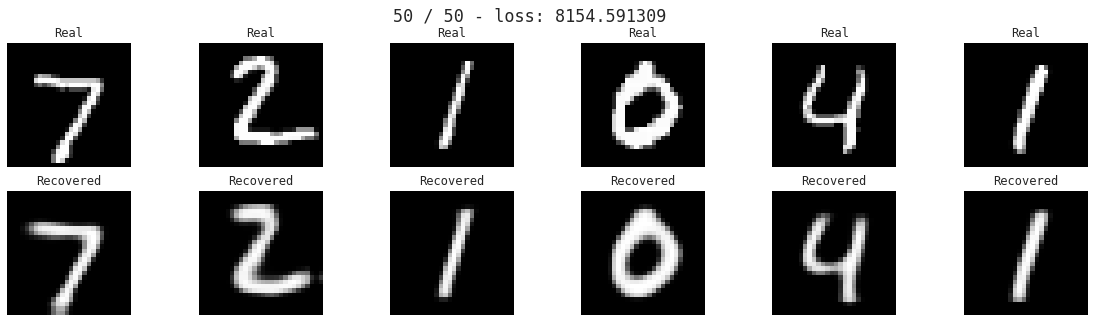

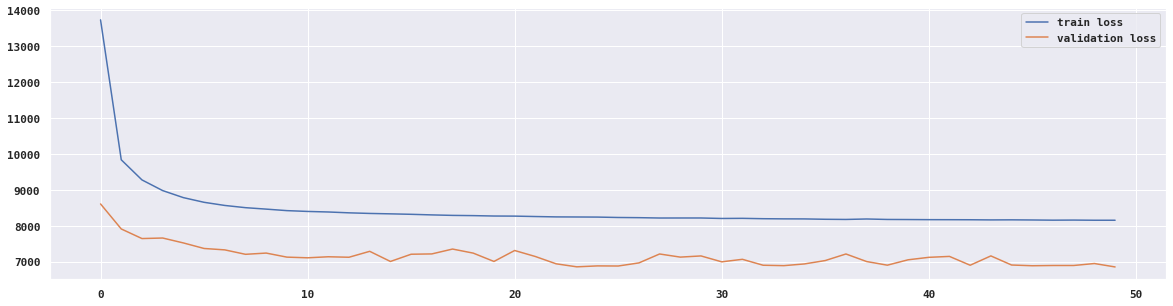

In [121]:
history = train_vae(train_dataloader, test_dataloader, EPOCHS, model, loss_fn, optimizer)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

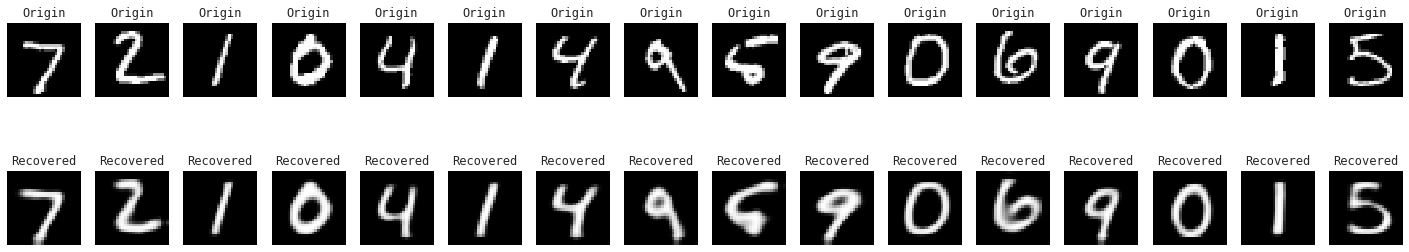

In [141]:
def plot_transformed_images(before: Iterable, after: Iterable,
                            count: int=12, figsize: tuple=(25,5)):
    plt.figure(figsize=figsize)
    for k in range(count):
        plt.subplot(2, count, k+1)
        plt.imshow(before[k].squeeze(), cmap='gray',
                   interpolation='nearest')
        plt.title('Origin')
        plt.axis('off')
        plt.subplot(2, count, k+count+1)
        plt.imshow(after[k].squeeze(), cmap='gray',
                   interpolation='nearest')
        plt.title('Recovered')
        plt.axis('off')
X_val = next(iter(test_dataloader))[0]
model.eval()
mu_val, log_sigma_val, reconstruction_val = model(X_val.to(device))
plot_transformed_images(X_val, reconstruction_val.detach().cpu().numpy(), count=16)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

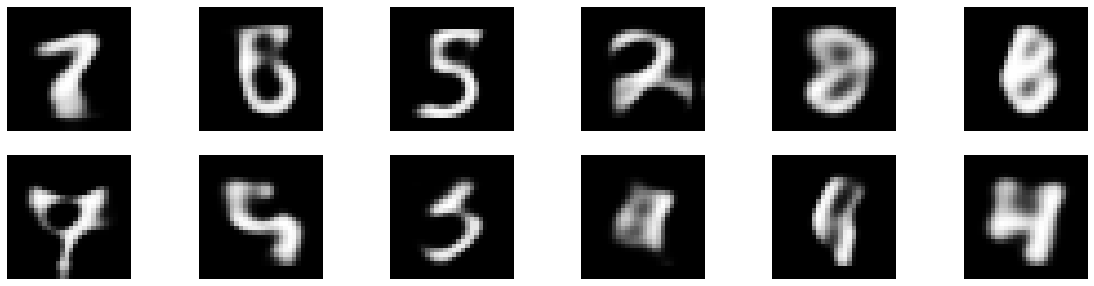

In [135]:
std_mu, std_sigma = 0, 1
z = std_mu + std_sigma * np.random.randn(15, features)
z = torch.from_numpy(z).float().to(device)
model.eval()
output = model.decode(z).detach().cpu()

fig, axes = plt.subplots(2, 6, figsize=(20,5))
for i, ax in enumerate(axes.flat):
    ax.imshow(output[i].numpy().squeeze(), cmap='gray',
              interpolation='nearest')
    ax.axis('off')

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [172]:
res = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_dataloader:
        mu, logsigma, _ = model(X_batch.to(device))
        res.append(model.gaussian_sampler(mu, logsigma).detach().cpu())
res = torch.cat(res)

In [36]:
def tsne_plot(reconstruction: torch.Tensor, dataloader: Iterable, figsize: tuple=(15,15)):
    tsne = TSNE()
    latent = tsne.fit_transform(reconstruction)
    plt.figure(figsize=figsize)
    sns.scatterplot(x=latent[:,0], y=latent[:,1], hue=test_dataset.targets, 
                    palette=sns.color_palette('Paired', 10))
    plt.show()

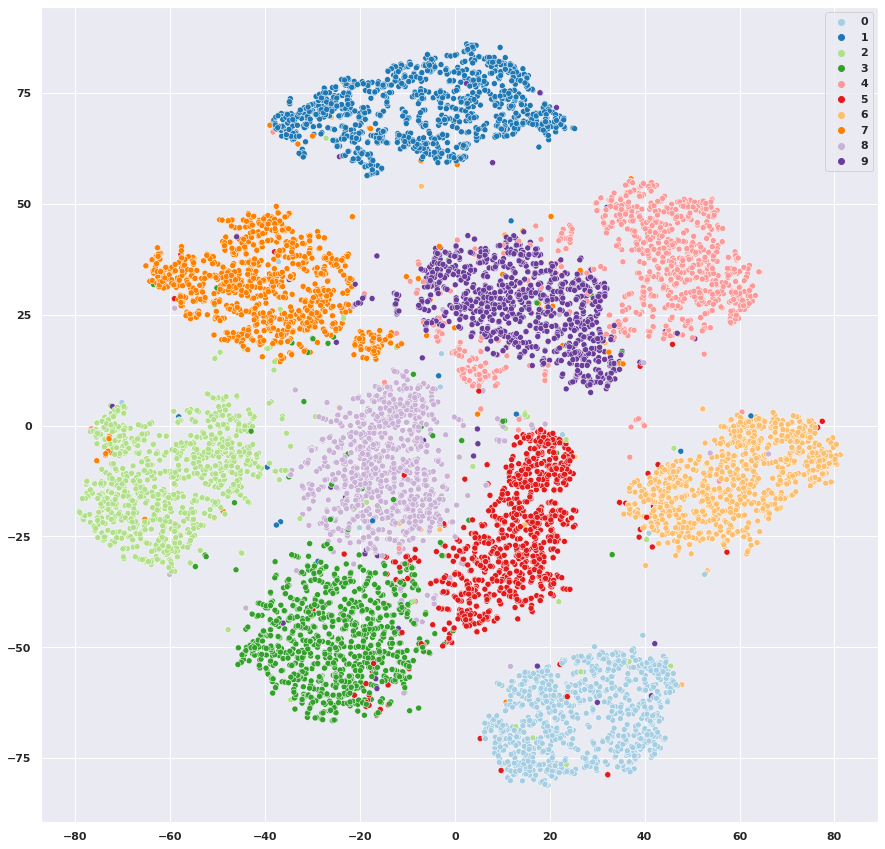

In [199]:
tsne_plot(res, test_dataset)

Четко разделимы кластеры цифр в латентном представлении

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [9]:
LABELS_COUNT = 10
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()
        self.flatten = nn.Flatten()

        self.encoder = nn.Sequential(
            nn.Linear(in_features=28*28 + 10, out_features=8192),
            nn.LeakyReLU(),
            nn.Dropout(p=0.8),
            nn.Linear(in_features=8192, out_features=2048),
            nn.LeakyReLU(),
            nn.Dropout(p=0.75),
            nn.Linear(in_features=2048, out_features=1024),
            nn.LeakyReLU(),
            nn.Dropout(p=0.75),
            nn.Linear(in_features=1024, out_features=features * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=features+10, out_features=1024),
            nn.LeakyReLU(),
            nn.Dropout(p=0.75),
            nn.Linear(in_features=1024, out_features=2048),
            nn.LeakyReLU(),
            nn.Dropout(p=0.75),
            nn.Linear(in_features=2048, out_features=8192),
            nn.LeakyReLU(),
            nn.Dropout(p=0.8),
            nn.Linear(in_features=8192, out_features=28*28),
            nn.Unflatten(1, (1, 28, 28))
        )

    def encode(self, x, class_num):
        class_num = F.one_hot(class_num, num_classes=LABELS_COUNT)
        x = torch.cat((self.flatten(x), class_num), dim=1)
        z = self.encoder(x).view(-1, 2, features)
        mu = z[:, 0, :]
        logsigma = z[:, 1, :]
        
        return mu, logsigma, class_num
    
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
        
    
    def decode(self, z, class_num):
        class_num = F.one_hot(class_num, num_classes=10)
        z = torch.cat((z, class_num), dim=1)
        reconstruction = self.decoder(z)
        return reconstruction
    

    def forward(self, x, class_num):
        mu, logsigma, _ = self.encode(self.flatten(x), class_num)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)
        
        return mu, logsigma, reconstruction

In [10]:
loss_fn = loss_vae

model = CVAE().to(device)

optimizer = optim.AdamW(model.parameters(), lr=5e-4)

In [13]:
EPOCHS=50

In [14]:
def train_cvae(data_tr: Iterable, data_val: Iterable, epochs: int,
            model: nn.Module, loss_fn: Callable, opt: torch.optim, 
            scheduler: torch.optim.lr_scheduler=None) -> dict:
    X_val, y_val = next(iter(data_val))
    history = []
    plotter = PlotterMNIST(epochs=epochs, count_photos=6)
    for epoch in range(epochs):
        with tqdm(data_tr, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch + 1}")
            avg_loss_train = 0
            avg_loss_val = 0
            model.train()  # train mode
            for X_batch, y_batch in tepoch:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                opt.zero_grad()
                # set parameter gradients to zero
                # forward
                mu, log_sigma, reconstruction = model(X_batch, y_batch)
                loss = loss_fn(X_batch, mu, log_sigma, reconstruction)# forward-pass
                loss.backward()  # backward-pass
                opt.step()  # update weights
                if scheduler:
                    scheduler.step()
                # calculate loss to show the user
                avg_loss_train += loss / len(data_tr)
            # show intermediate results
            model.eval()  # testing mode
            mu_val, log_sigma_val, reconstruction_val = model(X_val.to(device), y_val.to(device))
            # validation loss
            for X_batch, y_batch in data_val:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                with torch.set_grad_enabled(False):
                    mu, log_sigma, reconstruction = model(X_batch, y_batch)
                avg_loss_val += loss_fn(X_batch, mu, log_sigma, reconstruction) / len(data_val)
            history.append((avg_loss_train.item(), avg_loss_val.item()))
            # Visualize tools
            tepoch.update(1)           
            clear_output()
            plotter.plot_info(X_val, reconstruction_val, history, epoch=epoch, 
                        avg_loss_train=avg_loss_train)
    return history

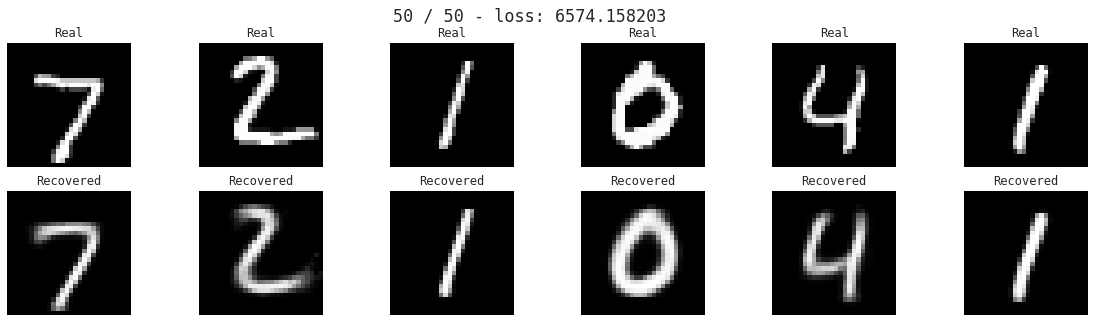

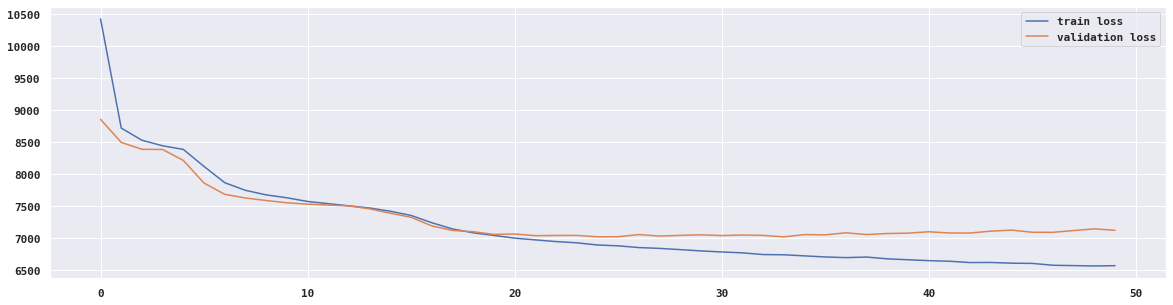

In [15]:
history = train_cvae(train_dataloader, test_dataloader, EPOCHS, model, loss_fn, optimizer)

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

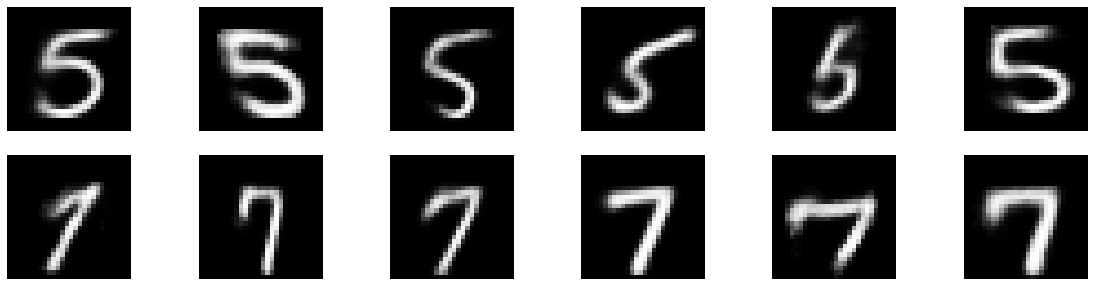

In [30]:
std_mu, std_sigma = 0, 1
z = std_mu + std_sigma * np.random.randn(12, features)
z = torch.from_numpy(z).float().to(device)
targets = torch.cat((torch.full((1,6), 5).squeeze(), torch.full((1,6), 7).squeeze())).to(device)
model.eval()
output = model.decode(z, targets).detach().cpu()

fig, axes = plt.subplots(2, 6, figsize=(20,5))
for i, ax in enumerate(axes.flat):
    ax.imshow(output[i].numpy().squeeze(), cmap='gray',
              interpolation='nearest')
    ax.axis('off')

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

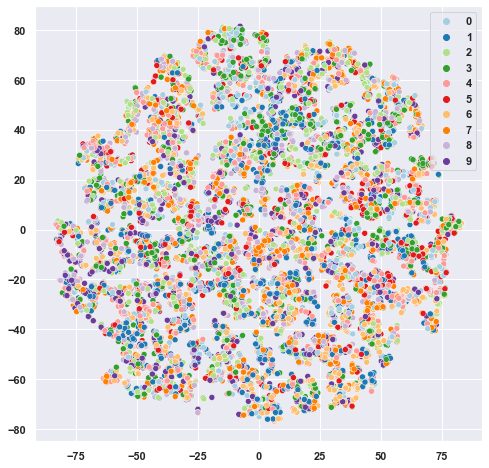

In [37]:
res = []
with torch.no_grad():
    model.eval()
    for X_batch, y_batch in test_dataloader:
        mu, logsigma, _ = model(X_batch.to(device), y_batch.to(device))
        res.append(model.gaussian_sampler(mu, logsigma).detach().cpu())
res = torch.cat(res)
tsne_plot(res, test_dataset, figsize=(8,8));

Отличие существенное, отчетливого разделения на кластеры не наблюдается